In [1]:
import numpy as np 
import pandas as pd
import torch

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from torch.utils.data import Dataset

class SignMnistDataset(Dataset):
    def __init__(self, csv_file, transform=None,target_transform=None):
        self.csv = pd.read_csv(csv_file)
        self.labels = self.csv["label"].to_numpy()
        self.data = self.csv.drop("label",axis=1).to_numpy(dtype=np.float32).reshape((-1,28,28)) 
        # self.data = self.data / 255
        self.transform = transform
        self.target_transform = target_transform
        self.labels_map = {
                            0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H", 8: "I",  10: "K", 11: "L", 12: "M", 13: "N", 
                            14: "O", 15: "P", 16: "Q", 17: "R", 18: "S", 19: "T", 20: "U", 21: "V", 22: "W", 23: "X", 24: "Y", 
                          }
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        label = self.labels[index]
        image = self.data[index]

        if self.transform:
            image = self.transform(image)

        # if self.target_transform:
        #     label = self.target_transform(label)

        return image, label

In [4]:
from torchvision.transforms import ToTensor

train_dataset = SignMnistDataset(r"./dataset/sign_mnist_train.csv",transform=ToTensor(),target_transform=ToTensor())
test_dataset = SignMnistDataset(r"./dataset/sign_mnist_test.csv",transform=ToTensor(),target_transform=ToTensor())


In [5]:
from torch.utils.data import DataLoader

train_mini_batch = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_mini_batch = DataLoader(test_dataset, batch_size=1024, shuffle=True)

In [6]:
from torch import nn 
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler



def train_model(model:torch.nn.Module, train_batch:DataLoader,test_batch:DataLoader,lr=1e-3,epoch_count=30,print_state=True):

    collected_data = {
        "epoch" : [],
        "training loss":[],
        "training accuracy":[],
        "test accuracy":[]
    }
    opt = Adam(model.parameters(),lr=lr)
    scheduler = lr_scheduler.LinearLR(opt, start_factor=1.0, end_factor=0.1, total_iters=epoch_count)
    loss_fn = nn.CrossEntropyLoss().to(DEVICE)
    
    opt.zero_grad()        

    for epoch in range(epoch_count):
        corect_guess_train = 0 
        for X,y in train_batch:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits =  model(X)
            loss = loss_fn(logits, y) 
            opt.zero_grad()        
            loss.backward()
            opt.step()
            
            with torch.no_grad():
                corect_guess_train += (torch.argmax(logits,dim=1) == y).int().sum().item()
        
        scheduler.step()

        train_acc = corect_guess_train/len(train_dataset)

        

        with torch.no_grad():
            corect_guess = 0

            for x,y in test_batch:
                x = x.to("cuda")
                corect_guess += (torch.argmax(model(x),dim=1) == y.to("cuda")).int().sum().item()

            test_acc = corect_guess / len(test_dataset)
            
        if print_state:
            print(f"epoch = {epoch} => loss = {loss.item()} => train acc {train_acc}") 
            print("test acc =", test_acc) 

        collected_data["epoch"].append(epoch)
        collected_data["training loss"].append(loss.item())
        collected_data["training accuracy"].append(train_acc)
        collected_data["test accuracy"].append(test_acc)

    
    return collected_data


def get_total_param_count(model:nn.Module):
    return sum(p.numel() for p in model.parameters())
        

In [10]:

class LinearNetwork(nn.Module):
    def __init__(self,hidden_layer_count=4,hidden_layer_width=64):
        super().__init__()
        

        self.hidden_layer_width = hidden_layer_width
        self.hidden_layer_count = hidden_layer_count

        self.hidden_layers = nn.ModuleList()        

        self.input_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,self.hidden_layer_width),
            nn.ReLU(),
            nn.BatchNorm1d(self.hidden_layer_width),
        )

        self.output_layer = nn.Sequential(
            nn.Linear(self.hidden_layer_width,25),
        )   

        for i in range(hidden_layer_count):
            self.hidden_layers.append( self.create_hidden_layer(self.hidden_layer_width) )
    
    def create_hidden_layer(self,width):
            return nn.Sequential(
                nn.Linear(width,width),
                nn.ReLU(),
                nn.BatchNorm1d(width),
            )

    def forward(self,x):
        out = self.input_layer(x)

        for hl in self.hidden_layers:
            out = hl(out)

        out = self.output_layer(out)
        
        return out

In [11]:
layer_list = [5, 10, 20,  40]
width_list = [64,128,256,512]

In [12]:
linear_networks = []
for l in layer_list:
    for w in width_list:
        ln = LinearNetwork(hidden_layer_count=l,hidden_layer_width=w)
        linear_networks.append(ln)


In [64]:
collected_datas = []
for ln in linear_networks:
    cd = train_model(ln.to(DEVICE),train_batch=train_mini_batch,test_batch=test_mini_batch,print_state=False)
    collected_datas.append(cd)

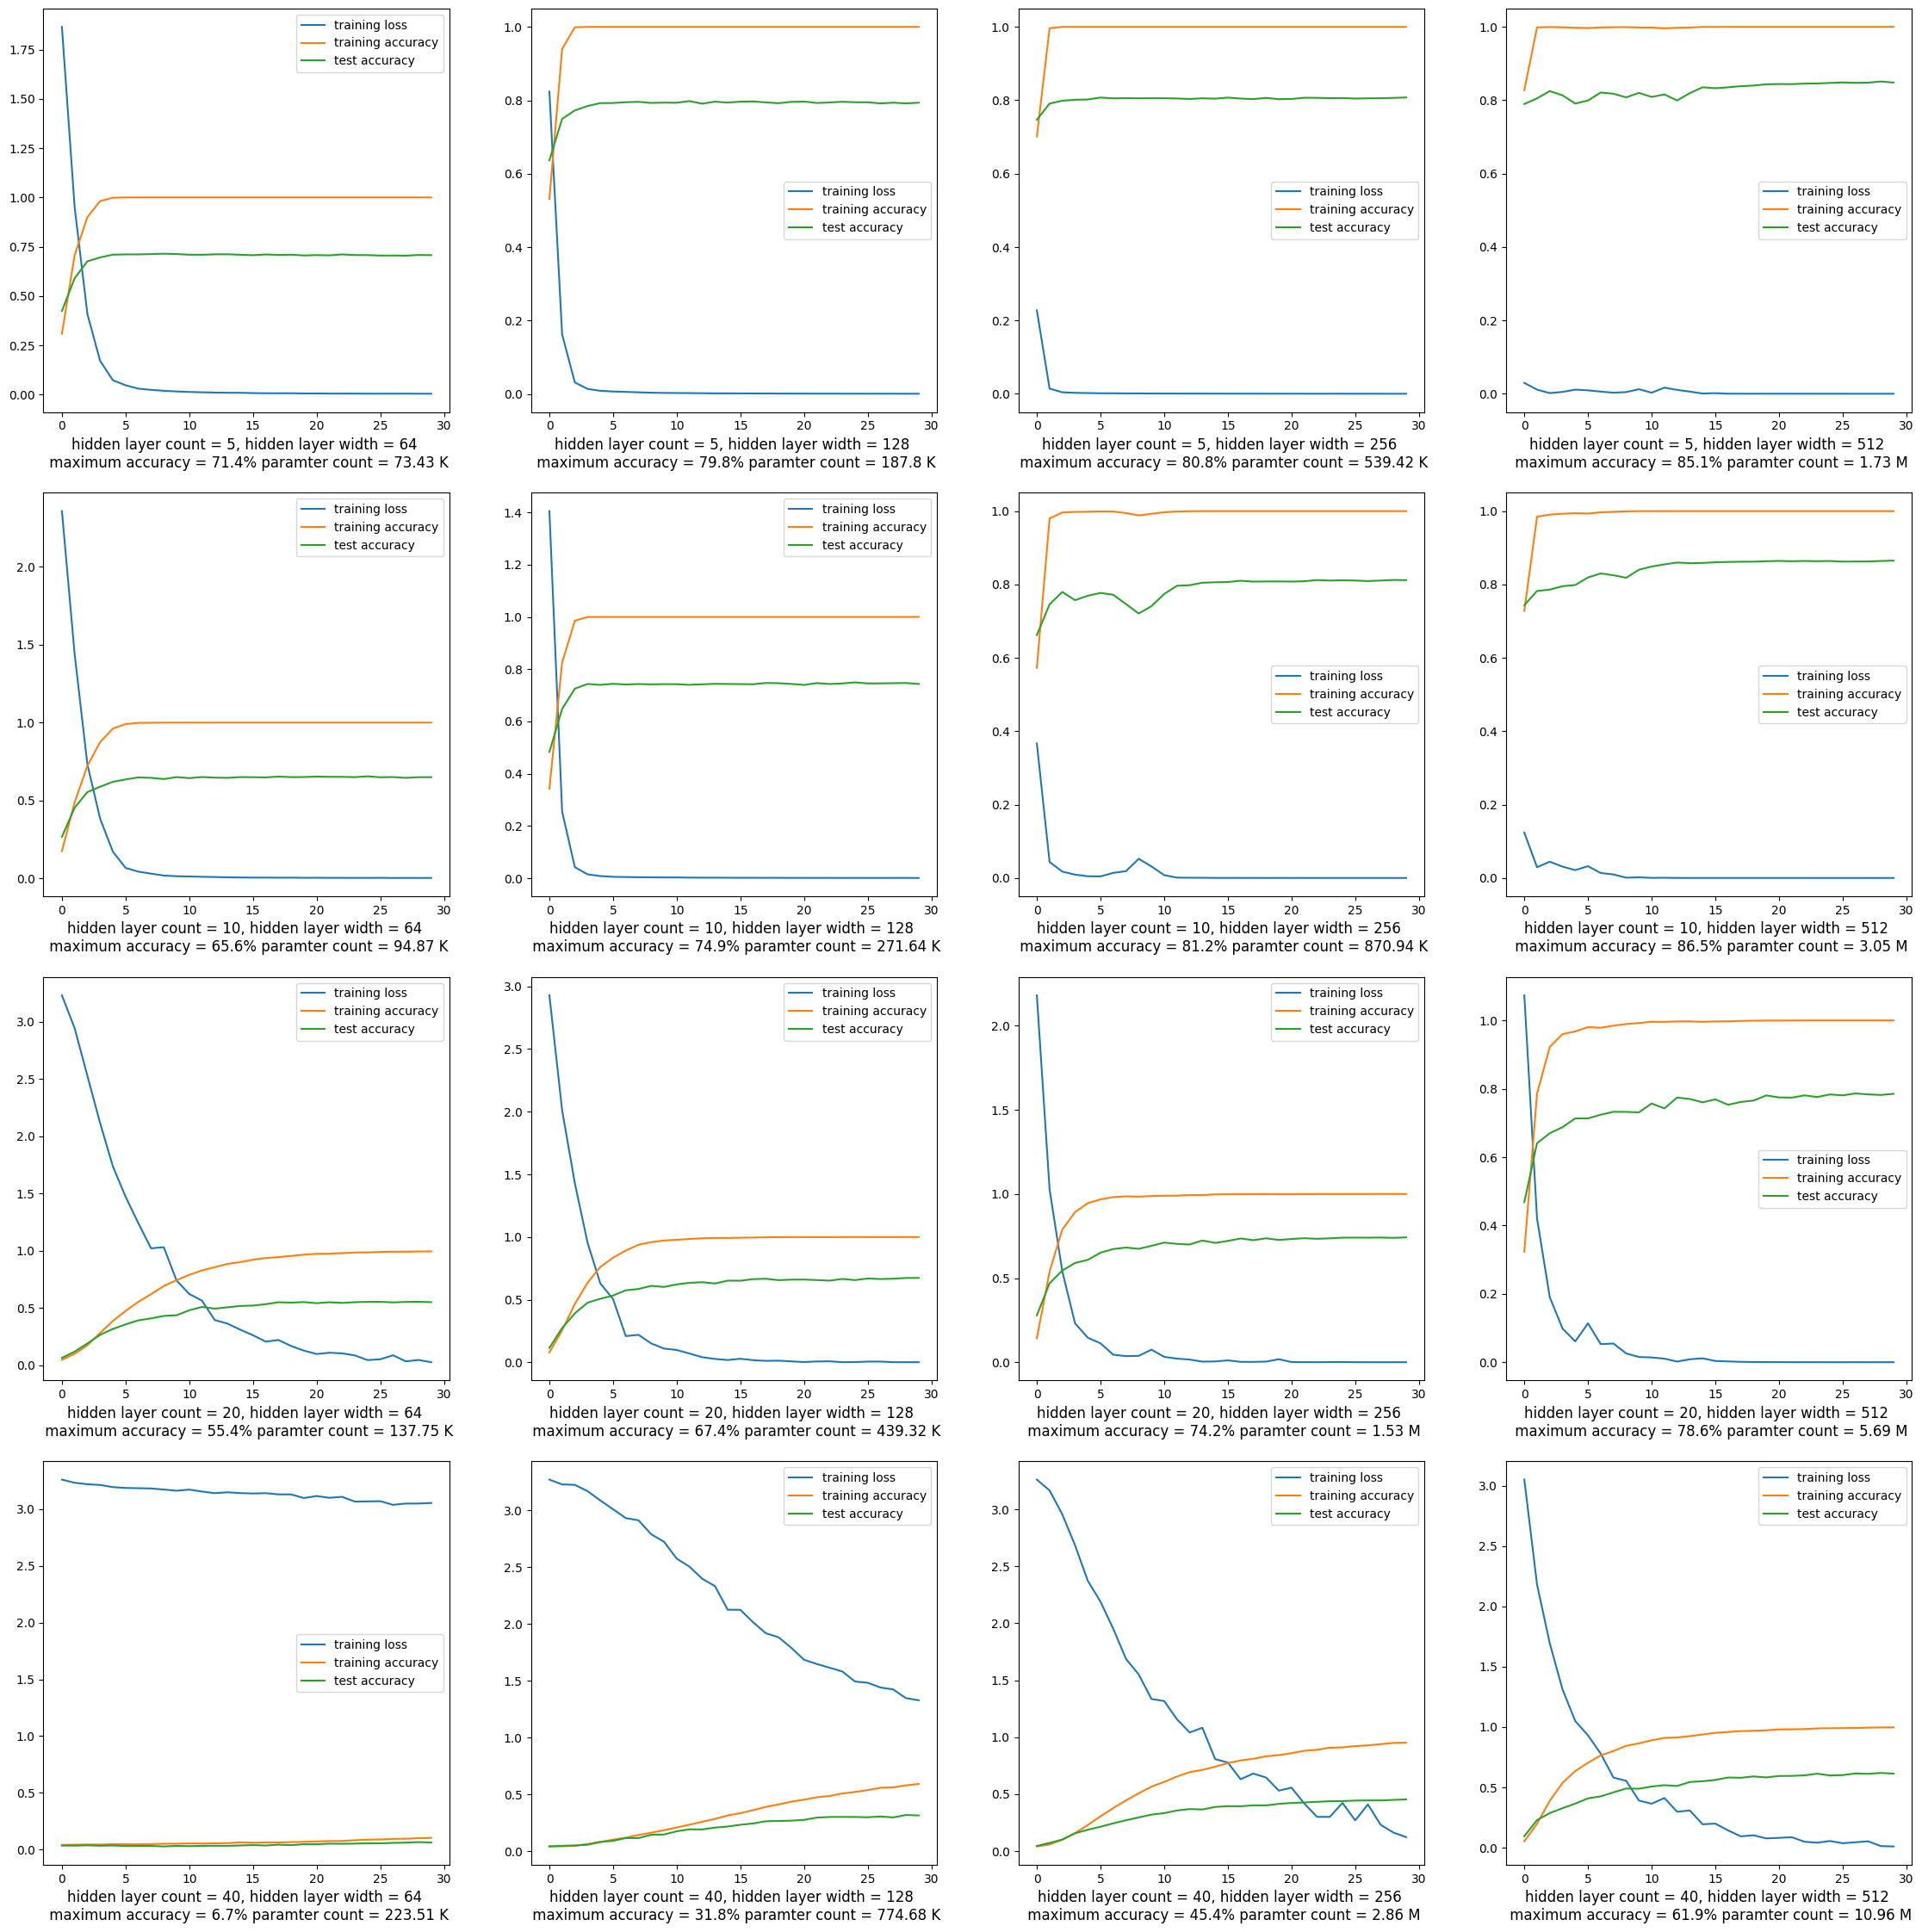

In [ ]:
import matplotlib.pyplot as plt

fg , axs = plt.subplots(4,4,figsize=(28,28))

axs = axs.reshape(-1)

for axis,network,data in zip(axs,linear_networks,collected_datas):
        axis.plot(data["epoch"], data["training loss"],label="training loss")
        axis.plot(data["epoch"], data["training accuracy"],label="training accuracy")
        axis.plot(data["epoch"], data["test accuracy"],label="test accuracy")

        max_acc = round(max(data["test accuracy"])* 100,1)

        param_count = get_total_param_count(network)
        if param_count > 1e6:
                param_count_display = f"{round(param_count / 1e6,2)} M" 
        else:
                param_count_display = f"{round(param_count / 1e3,2)} K"

        axis.set_xlabel(
        f"hidden layer count = {network.hidden_layer_count}, hidden layer width = {network.hidden_layer_width} \n maximum accuracy = {max_acc}% paramter count = {param_count_display}",fontsize=12)
        axis.legend()
plt.show()


In [200]:
def draw_single_label(model,collected_data):
    plt.plot(collected_data["epoch"], collected_data["training loss"],label="training loss")
    plt.plot(collected_data["epoch"], collected_data["training accuracy"],label="training accuracy")
    plt.plot(collected_data["epoch"], collected_data["test accuracy"],label="test accuracy")
    plt.legend()

    max_acc = round(max(collected_data["test accuracy"])* 100,1)

    param_count = get_total_param_count(model)
    if param_count > 1e6:
            param_count_display = f"{round(param_count / 1e6,2)} M" 
    else:
            param_count_display = f"{round(param_count / 1e3,2)} K"

    plt.xlabel(
    f"maximum accuracy = {max_acc}% paramter count = {param_count_display}",fontsize=12)
    plt.show()

In [216]:
class ConvolutionalLinearEndNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1,32,(3,3)), # 26,26,32,
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32,64,(3,3)),#24 24 64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2,2)), # 12, 12, 64

            nn.Conv2d(64,72,(3,3)), # 10,10,126
            nn.ReLU(),
            nn.BatchNorm2d(72),

            nn.Conv2d(72,96,(3,3)), # 8,8,256
            nn.Conv2d(96,108,(3,3)), # 6,6,256
            nn.ReLU(),
            nn.BatchNorm2d(108),
            nn.MaxPool2d((2,2)), # 3, 3, 64
            nn.Flatten(),
            nn.Linear(108*3*3,108),
            nn.Linear(108,25)        

        )
    def forward(self,x):
        out = self.network(x)
        return out

In [217]:
linear_end_network = ConvolutionalLinearEndNetwork().to(DEVICE)
collected_data = train_model(linear_end_network,train_batch=train_mini_batch,test_batch=test_mini_batch,print_state=True,epoch_count=10)   

epoch = 0 => loss = 0.035735368728637695 => train acc 0.8450555454379894
test acc = 0.9373954266592304
epoch = 1 => loss = 0.002604513429105282 => train acc 1.0
test acc = 0.9619353039598438
epoch = 2 => loss = 0.0011900938116014004 => train acc 1.0
test acc = 0.9631901840490797
epoch = 3 => loss = 0.0008335579186677933 => train acc 1.0
test acc = 0.9631901840490797
epoch = 4 => loss = 0.0007311886874958873 => train acc 1.0
test acc = 0.9638873396542108
epoch = 5 => loss = 0.0005717351450584829 => train acc 1.0
test acc = 0.9638873396542108
epoch = 6 => loss = 0.0005141938454471529 => train acc 1.0
test acc = 0.9636084774121584
epoch = 7 => loss = 0.0004922664957121015 => train acc 1.0
test acc = 0.9641662018962632
epoch = 8 => loss = 0.00039495748933404684 => train acc 1.0
test acc = 0.964026770775237
epoch = 9 => loss = 0.0003892012173309922 => train acc 1.0
test acc = 0.9644450641383157


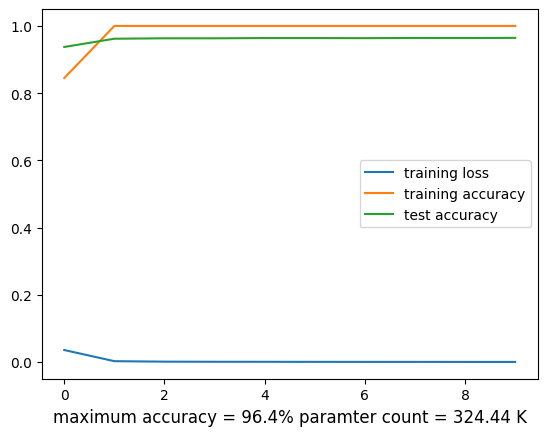

In [218]:
draw_single_label(linear_end_network,collected_data)

In [189]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1,32,(3,3)), # 26,26,32,
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32,64,(3,3)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2,2)), # 12, 12, 64

            nn.Conv2d(64,72,(3,3)), # 10,10,126
            nn.ReLU(),
            nn.BatchNorm2d(72),

            nn.Conv2d(72,96,(3,3)), # 6,6,256
            nn.Conv2d(96,108,(3,3)), # 6,6,256
            nn.ReLU(),
            nn.BatchNorm2d(108),
            nn.MaxPool2d((2,2)), # 3, 3, 64

            nn.Conv2d(108,25,(3,3)), # 1,1,25

        )
    def forward(self,x):
        out = self.network(x)
        rotate_out = out.view(-1,25)
        return rotate_out

In [190]:
convNetwork = ConvolutionalNetwork().to(DEVICE)

In [191]:
collected_data = train_model(convNetwork,train_batch=train_mini_batch,test_batch=test_mini_batch,print_state=True,epoch_count=10)   

epoch = 0 => loss = 0.057899560779333115 => train acc 0.8437078856310326
test acc = 0.9368377021751255
epoch = 1 => loss = 0.007003080099821091 => train acc 0.9998543070478966
test acc = 0.9546848856664808
epoch = 2 => loss = 0.0035818936303257942 => train acc 1.0
test acc = 0.9573340769659788
epoch = 3 => loss = 0.0024558203294873238 => train acc 1.0
test acc = 0.9577523703290575
epoch = 4 => loss = 0.0017806589603424072 => train acc 1.0
test acc = 0.9577523703290575
epoch = 5 => loss = 0.0015038197161629796 => train acc 1.0
test acc = 0.9590072504182934
epoch = 6 => loss = 0.001174437114968896 => train acc 1.0
test acc = 0.959425543781372
epoch = 7 => loss = 0.0010751321678981185 => train acc 1.0
test acc = 0.9595649749023982
epoch = 8 => loss = 0.0010690742637962103 => train acc 1.0
test acc = 0.9597044060234244
epoch = 9 => loss = 0.0009588434477336705 => train acc 1.0
test acc = 0.959425543781372


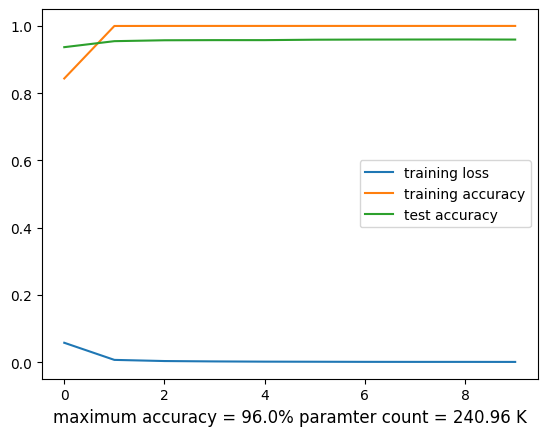

In [192]:
plt.plot(collected_data["epoch"], collected_data["training loss"],label="training loss")
plt.plot(collected_data["epoch"], collected_data["training accuracy"],label="training accuracy")
plt.plot(collected_data["epoch"], collected_data["test accuracy"],label="test accuracy")

max_acc = round(max(collected_data["test accuracy"])* 100,1)

param_count = get_total_param_count(convNetwork)
if param_count > 1e6:
        param_count_display = f"{round(param_count / 1e6,2)} M" 
else:
        param_count_display = f"{round(param_count / 1e3,2)} K"

plt.xlabel(
f"maximum accuracy = {max_acc}% paramter count = {param_count_display}",fontsize=12)
plt.legend()

In [196]:
torch.save(convNetwork.state_dict(), "sign_language_prediction.pt")